In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import optim
import torchvision
import matplotlib.pyplot as plt
from time import time
import os
from torchvision import datasets, transforms

In [2]:
batch_size = 64

In [3]:
# Importing train data
train_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train labels.csv", delimiter = ",")
train_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_up.csv", delimiter = ",")
train_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/train_data_down.csv", delimiter = ",")
train_labels = np.asarray(train_labels)
train_lab = train_labels[:, 0]
train_private_labels = train_labels[:, 1]
train_public_labels = train_labels[:, 2]
train_images_down = np.asarray(train_data_down.iloc[:,:])
train_images_up = np.asarray(train_data_up.iloc[:,:])

# Importing test data
test_labels = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test labels.csv", delimiter = ",")
test_data_down = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_down.csv", delimiter = ",")
test_data_up = pd.read_csv("/nfs/stak/users/anandy/research/dataset/MNIST/test_data_up.csv", delimiter = ",")
test_labels = np.asarray(test_labels)
test_lab = test_labels[:, 0]
test_private_labels = test_labels[:, 1]
test_public_labels = test_labels[:, 2]
test_images_down = np.asarray(test_data_down.iloc[:,:])
test_images_up = np.asarray(test_data_up.iloc[:,:])

# Importing full sized train and test images and labels
full_train_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/train_data.csv', delimiter=",")
full_test_data = pd.read_csv('/nfs/stak/users/anandy/research/dataset/MNIST/test_data.csv', delimiter=",")
tr_img = np.asarray(full_train_data)
te_img = np.asarray(full_test_data)
train_images = tr_img[:, 3:]
test_images = te_img[:, 3:]

transform = transforms.Compose([transforms.ToTensor()])

In [4]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, private_labels=None, public_labels=None, transforms=None):
        self.images = images
        self.labels = labels
        self.private_labels = private_labels
        self.public_labels = public_labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.images))
    
    def __getitem__(self, idx):
        images = self.images[idx, :]
        images = np.asarray(images).astype(np.uint8)
        # print("type: ", type(images))
        images = np.reshape(images, [28, 56])
        
        labels = self.labels[idx][0]
        private_labels = self.private_labels[idx]
        public_labels = self.public_labels[idx]
        
        if self.transforms:
            images = self.transforms(images)
            
        return images, labels, private_labels, public_labels

train_data = MNISTDataset(train_images, train_labels, train_private_labels, train_public_labels, transform)
test_data = MNISTDataset(test_images, test_labels, test_private_labels, test_public_labels, transform)

# dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(train_loader)
images, labels, pr_labels, pu_labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 56])
torch.Size([64])


tensor(0) tensor(1)


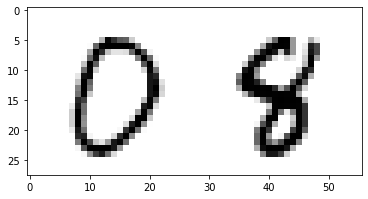

In [6]:
plt.imshow(images[10].cpu().numpy().squeeze(), cmap='gray_r')
print(pr_labels[10], pu_labels[10])

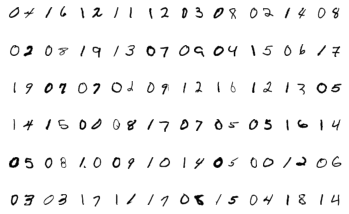

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
from torch import nn

# Layer details for the neural network
input_size = 1568
hidden_sizes = [1024, 512, 256, 128, 64]
output_size = 20

# Build a feed-forward network
san_model = nn.Sequential(nn.Linear(1568, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128))
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[3], hidden_sizes[4]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[4], output_size),
#                       nn.LogSoftmax(dim=1))
print(san_model)
                          
pr_model = nn.Sequential(nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())

pu_model = nn.Sequential(nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1),
                        nn.Sigmoid())




Sequential(
  (0): Linear(in_features=1568, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=128, bias=True)
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
san_model.to(device)
pr_model.to(device)
pu_model.to(device)

cuda


Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

In [10]:
criterion = nn.BCELoss()
images, labels, pr_labels, pu_labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
pu_labels = pu_labels.to(device)
pu_labels = pu_labels.type(torch.cuda.FloatTensor)
pu_labels = pu_labels.view(pu_labels.size(0), -1)

san_output = san_model(images)
pr_output = pr_model(san_output)
# print(pr_labels.size())
pr_loss = criterion(pr_output, pr_labels)
pu_output = pu_model(san_output)
pu_loss = criterion(pu_output, pu_labels)

In [11]:
print(san_model[0].weight.grad)
print(pr_model[0].weight.grad)
print(pu_model[0].weight.grad)

None
None
None


In [12]:
print('Before private model backward pass: \n', pr_model[0].weight.grad)
print('Before public model backward pass: \n', pu_model[0].weight.grad)

pr_loss.backward(retain_graph=True)
pu_loss.backward()

print('After private model backward pass: \n', pr_model[0].weight.grad)
print('After public model backward pass: \n', pu_model[0].weight.grad)

Before private model backward pass: 
 None
Before public model backward pass: 
 None
After private model backward pass: 
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-1.2565e-04, -1.7680e-04,  4.6265e-05,  ...,  2.0424e-05,
         -1.7148e-04,  1.5315e-04],
        [ 2.2274e-04,  3.1355e-04, -8.0390e-05,  ..., -3.6259e-05,
          3.0248e-04, -2.7155e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')
After public model backward pass: 
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.1984e-04, -1.5084e-04, -2.9985e-05,  ...,  7.1746e-06,
         -1.3421e-04,  

In [13]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
pr_optimizer = optim.SGD(pr_model.parameters(), lr=0.01, momentum=0.5)
pu_optimizer = optim.SGD(pu_model.parameters(), lr=0.01, momentum=0.5)

In [14]:
print('Initial private model weights - ', pr_model[0].weight)
print('Initial public model weights - ', pu_model[0].weight)

images, labels, pr_labels, pu_labels = next(iter(train_loader))
# images.resize_(64, 1568)
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
pu_labels = pu_labels.to(device)
pu_labels = pu_labels.type(torch.cuda.FloatTensor)
pu_labels = pu_labels.view(pu_labels.size(0), -1)

# Clear the gradients, do this because gradients are accumulated
pr_optimizer.zero_grad()
pu_optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
san_output = san_model(images)
pr_output = pr_model(san_output)
pr_loss = criterion(pr_output, pr_labels)
pr_loss.backward(retain_graph=True)
pu_output = pu_model(san_output)
pu_loss = criterion(pu_output, pu_labels)
pu_loss.backward()

print('Private Gradient -', pr_model[0].weight.grad)
print('Public Gradient - ', pu_model[0].weight.grad)

Initial private model weights -  Parameter containing:
tensor([[ 0.0170, -0.0207,  0.0657,  ...,  0.0302, -0.0362, -0.0302],
        [ 0.0877,  0.0794,  0.0634,  ..., -0.0695,  0.0387, -0.0268],
        [-0.0498,  0.0821, -0.0118,  ..., -0.0438, -0.0003,  0.0455],
        ...,
        [-0.0729, -0.0097, -0.0735,  ...,  0.0290,  0.0449, -0.0842],
        [-0.0781,  0.0700, -0.0053,  ..., -0.0467, -0.0526, -0.0345],
        [ 0.0707, -0.0596, -0.0255,  ..., -0.0664,  0.0277,  0.0407]],
       device='cuda:0', requires_grad=True)
Initial public model weights -  Parameter containing:
tensor([[ 0.0581,  0.0275,  0.0786,  ..., -0.0842,  0.0373,  0.0067],
        [ 0.0296, -0.0185,  0.0475,  ..., -0.0607,  0.0597, -0.0591],
        [-0.0763, -0.0041,  0.0516,  ..., -0.0677, -0.0736, -0.0834],
        ...,
        [ 0.0376,  0.0747, -0.0342,  ..., -0.0459, -0.0267, -0.0007],
        [ 0.0839, -0.0806, -0.0196,  ...,  0.0669, -0.0865, -0.0187],
        [ 0.0324,  0.0425, -0.0403,  ..., -0.0767,

In [15]:
pr_optimizer.step()
print('Updated private model weights - ', pr_model[0].weight)
pu_optimizer.step()
print('Updated public model weights - ', pu_model[0].weight)

Updated private model weights -  Parameter containing:
tensor([[ 0.0170, -0.0207,  0.0657,  ...,  0.0302, -0.0362, -0.0302],
        [ 0.0877,  0.0794,  0.0634,  ..., -0.0695,  0.0387, -0.0268],
        [-0.0498,  0.0821, -0.0118,  ..., -0.0438, -0.0003,  0.0455],
        ...,
        [-0.0729, -0.0097, -0.0735,  ...,  0.0290,  0.0449, -0.0842],
        [-0.0781,  0.0700, -0.0053,  ..., -0.0467, -0.0526, -0.0345],
        [ 0.0707, -0.0596, -0.0255,  ..., -0.0664,  0.0277,  0.0407]],
       device='cuda:0', requires_grad=True)
Updated public model weights -  Parameter containing:
tensor([[ 0.0581,  0.0275,  0.0786,  ..., -0.0842,  0.0373,  0.0067],
        [ 0.0296, -0.0185,  0.0475,  ..., -0.0607,  0.0597, -0.0591],
        [-0.0763, -0.0041,  0.0516,  ..., -0.0677, -0.0736, -0.0834],
        ...,
        [ 0.0376,  0.0747, -0.0342,  ..., -0.0459, -0.0267, -0.0007],
        [ 0.0839, -0.0806, -0.0196,  ...,  0.0669, -0.0865, -0.0187],
        [ 0.0324,  0.0425, -0.0403,  ..., -0.0767,

In [16]:
pr_optimizer = optim.SGD(pr_model.parameters(), lr=0.001, momentum=0.9)
pu_optimizer = optim.SGD(pu_model.parameters(), lr=0.001, momentum=0.9)
san_optimizer = optim.SGD(san_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCELoss()

time0 = time()
epochs = 200
for e in range(epochs):
    running_loss = 0
    pr_running_loss = 0
    pu_running_loss = 0
    for idx, (images, labels, pr_labels, pu_labels)in enumerate(train_loader):
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.cuda.FloatTensor)
        labels = labels.view(labels.size(0), -1)
        pr_labels = pr_labels.to(device)
        pr_labels = pr_labels.type(torch.cuda.FloatTensor)
        pr_labels = pr_labels.view(pr_labels.size(0), -1)
        pu_labels = pu_labels.to(device)
        pu_labels = pu_labels.type(torch.cuda.FloatTensor)
        pu_labels = pu_labels.view(pu_labels.size(0), -1)    
        
        # Training pass
        if idx%80 != 0:
            pr_optimizer.zero_grad()
            pu_optimizer.zero_grad()
        
            san_output = san_model(images)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            pr_loss.backward(retain_graph=True)
            
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            pu_loss.backward(retain_graph=True)
            
            pr_optimizer.step()
            pu_optimizer.step()
            
            pr_running_loss += pr_loss.item()
            pu_running_loss += pu_loss.item()
            
        if idx%80 == 0:
            san_optimizer.zero_grad()
            san_output = san_model(images)
            
            pr_output = pr_model(san_output)
            pr_loss = criterion(pr_output, pr_labels)
            
            pu_output = pu_model(san_output)
            pu_loss = criterion(pu_output, pu_labels)
            
            loss = (pu_loss) - pr_loss
            loss.backward()
            san_optimizer.step()
        
            running_loss += loss.item()
    else:
        print("Training Epoch {} - San loss: {}, Private loss: {}, Public loss: {}".format(e, running_loss/len(train_loader), pr_running_loss/len(train_loader), pu_running_loss/len(train_loader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Training Epoch 0 - San loss: -2.545354616306627e-05, Private loss: 0.6839767956672727, Public loss: 0.6842018207320777
Training Epoch 1 - San loss: 3.186333209962186e-05, Private loss: 0.6821676332627415, Public loss: 0.6841980731090926
Training Epoch 2 - San loss: 2.6175585549200892e-05, Private loss: 0.6821235643933191, Public loss: 0.6841691840640114
Training Epoch 3 - San loss: 7.92905650175441e-05, Private loss: 0.6821453834281248, Public loss: 0.6841362056982182
Training Epoch 4 - San loss: 7.687009813840432e-05, Private loss: 0.6821152313286082, Public loss: 0.6841334369786255
Training Epoch 5 - San loss: 3.175151622508798e-05, Private loss: 0.6820548802537991, Public loss: 0.68412290959407
Training Epoch 6 - San loss: 2.311196778436451e-05, Private loss: 0.6819851889329798, Public loss: 0.6840891907434634
Training Epoch 7 - San loss: 3.966292761780722e-05, Private loss: 0.6819863560254616, Public loss: 0.6840754329700909
Training Epoch 8 - San loss: 1.6442954997577325e-05, Priv

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0035,  0.0042, -0.0024,  ..., -0.0023,  0.0014, -0.0029],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0021,  0.0026, -0.0015,  ..., -0.0014,  0.0008, -0.0018],
        [-0.0003,  0.0004, -0.0002,  ..., -0.0002,  0.0001, -0.0003]],
       device='cuda:0')


In [124]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.cpu().resize_(1, 28, 56).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(1), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(1))
    ax2.set_yticklabels(np.arange(1))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Public label = [1.]
Private model output value =  0.5285854935646057
Predicted Private label = [1.]


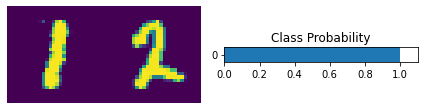

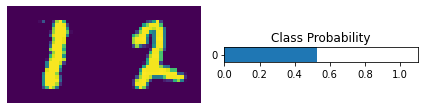

In [155]:
images, labels, pr_labels, pu_labels = next(iter(test_loader))
images = images.view(images.shape[0], -1)
images = images.to(device)
labels = labels.to(device)
labels = labels.type(torch.cuda.FloatTensor)
labels = labels.view(labels.size(0), -1)
pr_labels = pr_labels.to(device)
pr_labels = pr_labels.type(torch.cuda.FloatTensor)
pr_labels = pr_labels.view(pr_labels.size(0), -1)
pu_labels = pu_labels.to(device)
pu_labels = pu_labels.type(torch.cuda.FloatTensor)
pu_labels = pu_labels.view(pu_labels.size(0), -1) 

pu_acc = 0
# Turn off gradients to speed up this part
i = 10
img = images[i].view(1, 1568)

with torch.no_grad():
    san_output = san_model(img)
    pr_output = pr_model(san_output)
    pr_out = pr_output.reshape(-1).cpu().detach().numpy().round()
    pu_output = pu_model(san_output)
    pu_out = pu_output.reshape(-1).cpu().detach().numpy().round()
#     if (pu_out == pu_labels[i]):
#         pu_acc += 1
#     print(pu_output.reshape(-1).cpu().detach().numpy().round())
#     print(pu_labels[i])
print("Predicted Public label =", pu_out)
view_classify(img.view(1, 28, 56), pu_output)
print("Private model output value = ", pr_output.item())
print("Predicted Private label =", pr_out)
view_classify(img.view(1, 28, 56), pr_output)

In [156]:
pr_correct_count, pu_correct_count, all_count = 0, 0, 0
for images,labels, pr_labels, pu_labels in test_loader:
    images = images.view(images.shape[0], -1)
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.type(torch.cuda.FloatTensor)
    labels = labels.view(labels.size(0), -1)
    pr_labels = pr_labels.to(device)
    pr_labels = pr_labels.type(torch.cuda.FloatTensor)
    pr_labels = pr_labels.view(pr_labels.size(0), -1)
    pu_labels = pu_labels.to(device)
    pu_labels = pu_labels.type(torch.cuda.FloatTensor)
    pu_labels = pu_labels.view(pu_labels.size(0), -1) 
    
    for i in range(len(labels)):
        img = images[i].view(1, 1568)
        # Turn off gradients to speed up this part
        with torch.no_grad():
            san_output = san_model(img)
            pr_output = pr_model(san_output)
            pu_output = pu_model(san_output)

        # Output of the network are log-probabilities, need to take exponential for probabilities
        pr_pred_label = pr_output.reshape(-1).cpu().detach().numpy().round()
        pr_true_label = pr_labels.cpu().numpy()[i]
        if (pr_true_label == pr_pred_label):
            pr_correct_count += 1
            
        pu_pred_label = pu_output.reshape(-1).cpu().detach().numpy().round()
        pu_true_label = pu_labels.cpu().numpy()[i]
        if (pu_true_label == pu_pred_label):
            pu_correct_count += 1
            
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nPrivate Model Accuracy =", (pr_correct_count/all_count))
print("\nPublic Model Accuracy = ", (pu_correct_count/all_count))

Number Of Images Tested = 4999

Private Model Accuracy = 0.4890978195639128

Public Model Accuracy =  0.9675935187037408
